In [1]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

In [2]:
# If you are working in Colab, then consider mounting folder to your drive
from google.colab import drive
drive.mount('/content/drive')

# Direct to your folder.
%cd /content/drive/MyDrive/computer_vision/diffusion_models/

Mounted at /content/drive
/content/drive/MyDrive/computer_vision/diffusion_models


In [4]:
import torch
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel three times
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize all three channels
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

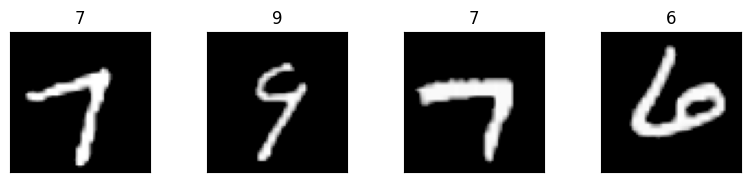

In [5]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

images = np.transpose(images, (0, 2, 3, 1))
images = np.clip(images, 0, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx])
    ax.set_title(str(labels[idx].item()))

plt.show()

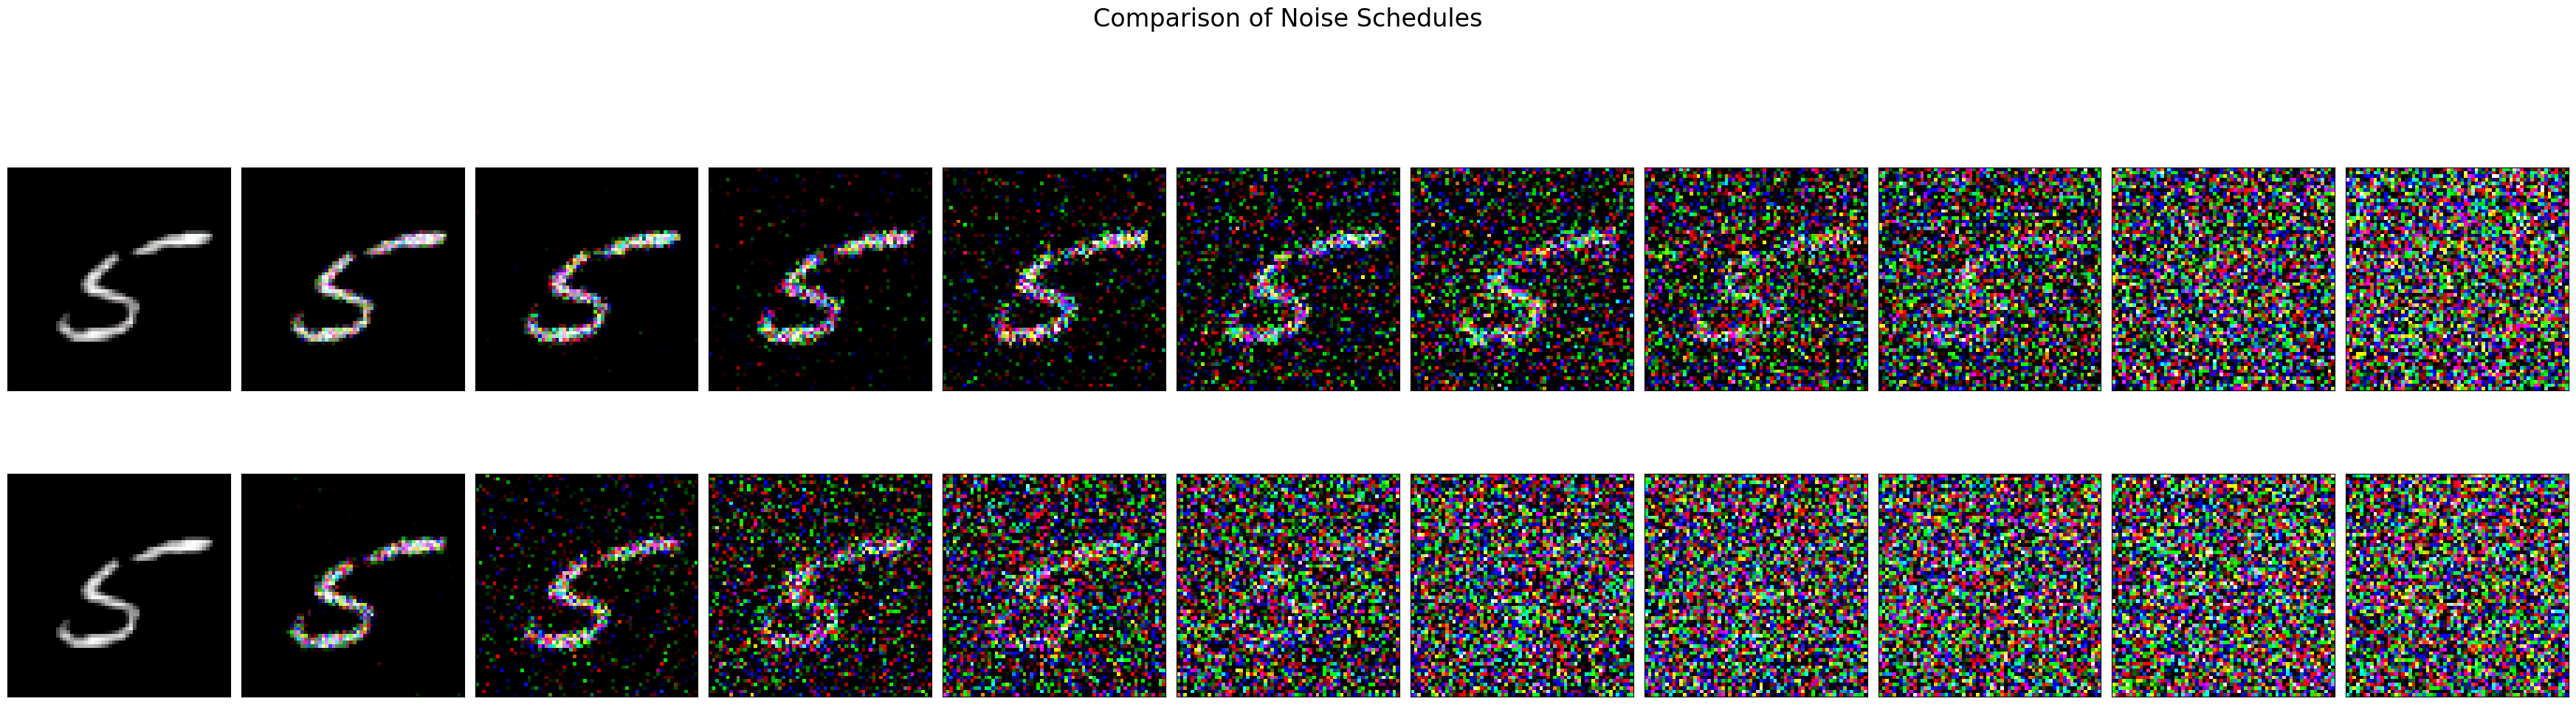

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from ddpm import Diffusion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = next(iter(trainloader))[0].shape[-1]

diffusion_cosine = Diffusion(noise_steps=1000, schedule_type='cosine', img_size=img_size, device=device)
diffusion_linear = Diffusion(noise_steps=1000, schedule_type='linear', img_size=img_size, device=device)

dataiter = iter(trainloader)
images, labels = next(dataiter)

single_image = images[0:1].to(device)

timesteps = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999])

fig = plt.figure(figsize=(35, 12))

for idx, t in enumerate(timesteps):
    t_tensor = torch.tensor([t], dtype=torch.long).to(single_image.device)

    # Generate noise images with cosine schedule
    noised_image_cosine, _ = diffusion_cosine.noise_images(single_image.clone(), t_tensor)
    noised_image_cosine = noised_image_cosine.squeeze().cpu().numpy()
    noised_image_cosine = np.transpose(noised_image_cosine, (1, 2, 0))
    noised_image_cosine = np.clip(noised_image_cosine, 0, 1)

    # Generate noise images with linear schedule
    noised_image_linear, _ = diffusion_linear.noise_images(single_image.clone(), t_tensor)
    noised_image_linear = noised_image_linear.squeeze().cpu().numpy()
    noised_image_linear = np.transpose(noised_image_linear, (1, 2, 0))
    noised_image_linear = np.clip(noised_image_linear, 0, 1)

    ax1 = fig.add_subplot(2, len(timesteps), idx + 1, xticks=[], yticks=[])
    ax1.imshow(noised_image_cosine)

    ax2 = fig.add_subplot(2, len(timesteps), len(timesteps) + idx + 1, xticks=[], yticks=[])
    ax2.imshow(noised_image_linear)

fig.suptitle('Comparison of Noise Schedules', fontsize=24, y=0.95)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
from ddpm import Diffusion, Trainer, UNet
import torch

img_size = next(iter(trainloader))[0].shape[-1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet(in_channels=3, out_channels=3, timestep_dim=256, device=device)
diffusion = Diffusion(noise_steps=1000, schedule_type='cosine', img_size=img_size, device=device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

trainer = Trainer(model=unet,
                  diffusion=diffusion,
                  optimizer=optimizer,
                  criterion=criterion,
                  trainloader=trainloader,
                  testloader=testloader,
                  save_path='mnist_ddpm.pth',
                  device=device)

In [ ]:
trainer.train_model(epochs=3)

In [16]:
# load the model
trained_unet = UNet(in_channels=3, out_channels=3, timestep_dim=256)
trained_unet.load_state_dict(torch.load('models/mnist_ddpm.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

Generating images: 1000it [00:00, 2001.09it/s]


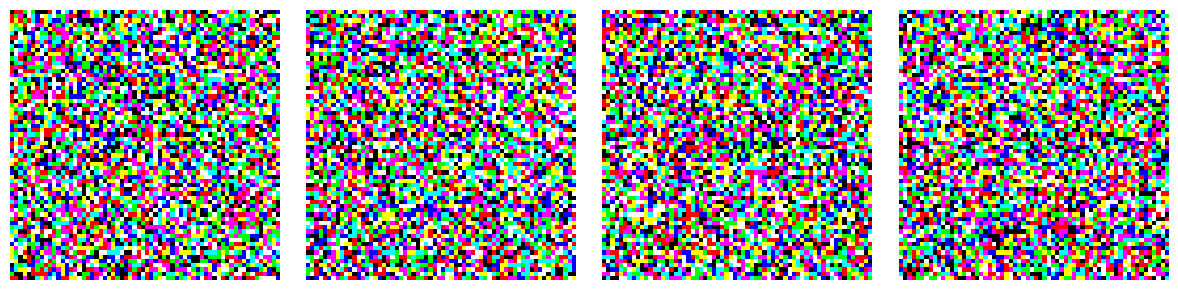

In [14]:
# test the model
generated_images = diffusion.generate_images(trained_unet)
generated_images = np.clip(generated_images.cpu(), 0, 1)

fig, axs = plt.subplots(1, 4, figsize=(4 * 3, 3))
for i, ax in enumerate(axs.flat):
    img = generated_images[i].cpu().permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [17]:
trainer = Trainer(model=trained_unet,
                  diffusion=diffusion,
                  optimizer=optimizer,
                  criterion=criterion,
                  trainloader=trainloader,
                  testloader=testloader,
                  save_path='mnist_ddpm.pth',
                  device=device)

average_losses = trainer.eval_model()

Evaluating model: 100%|██████████| 2500/2500 [01:45<00:00, 23.73it/s]

Average losses per timestep: [0.07985055480491031, 0.04945430774241686, 0.04347294755280018, 0.035634029656648636, 0.03567230062825339, 0.03547697216272354, 0.026364212855696678, 0.03021326560813647, 0.025711373292974064, 0.026095094857737422, 0.020872287452220917, 0.0241162056918256, 0.018505160696804523, 0.02014484857632355, 0.027219645058115322, 0.02059978370865186, 0.02091862043986718, 0.019693987105380405, 0.020485371196021635, 0.01533672639301845, 0.020491255354136227, 0.017339435612989798, 0.01790518576109951, 0.0181638038801876, 0.018048418996234734, 0.019331109151244162, 0.015786282407740753, 0.017694680485874414, 0.01592602101819856, 0.017432455671951175, 0.016461901366710663, 0.015736375728415117, 0.015851828184994785, 0.013935912333961045, 0.013590896635183267, 0.01438889517025514, 0.01723013983832465, 0.015803392355640728, 0.016745217726565897, 0.01425383733585477, 0.014283564536728792, 0.014319494677086672, 0.012339888140559196, 0.012529156969061919, 0.011851973069662397,

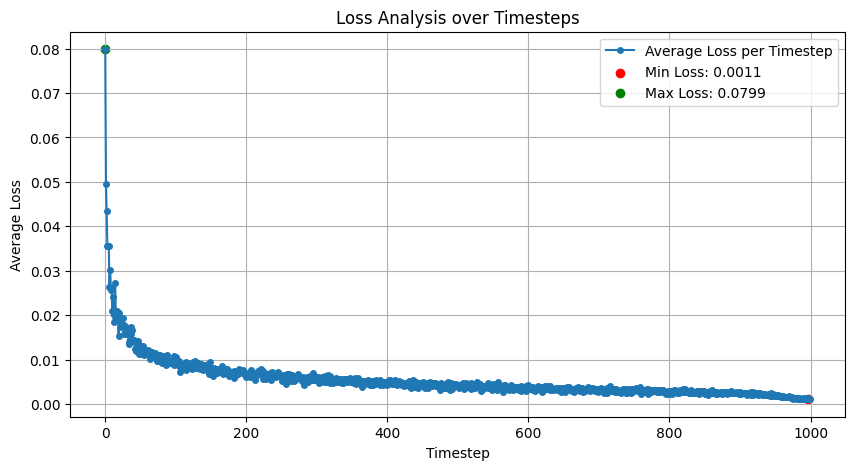

Minimum Loss: 0.0011
Maximum Loss: 0.0799
Average Loss: 0.0055
Standard Deviation of Loss: 0.0050


In [20]:
average_losses = np.array([x if x is not None else np.nan for x in average_losses])

# Calculate statistics ignoring NaN
min_loss = np.nanmin(average_losses)
max_loss = np.nanmax(average_losses)
mean_loss = np.nanmean(average_losses)
std_loss = np.nanstd(average_losses)

# Generate timesteps array
timesteps = np.arange(len(average_losses))

# Create a plot of average losses per timestep
plt.figure(figsize=(10, 5))
plt.plot(timesteps, average_losses, label='Average Loss per Timestep', linestyle='-', marker='o', markersize=4)
plt.scatter(timesteps[np.nanargmin(average_losses)], min_loss, color='red', label=f'Min Loss: {min_loss:.4f}')  # Min point
plt.scatter(timesteps[np.nanargmax(average_losses)], max_loss, color='green', label=f'Max Loss: {max_loss:.4f}')  # Max point
plt.title('Loss Analysis over Timesteps')
plt.xlabel('Timestep')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print the statistics
print(f"Minimum Loss: {min_loss:.4f}")
print(f"Maximum Loss: {max_loss:.4f}")
print(f"Average Loss: {mean_loss:.4f}")
print(f"Standard Deviation of Loss: {std_loss:.4f}")